In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import keras
import matplotlib.pyplot as plt
import h5py
import itertools

from sklearn.metrics import precision_score, recall_score, roc_auc_score, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D, Input, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adamax
from tensorflow.keras.applications import VGG16, InceptionResNetV2, ResNet50, Xception
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall, AUC, TruePositives, TrueNegatives, FalsePositives, FalseNegatives
from keras_tuner.tuners import RandomSearch
import keras_tuner as kt
import kerastuner as kt
from glob import glob
from keras_tuner import HyperParameters
from kerastuner import HyperParameters
from tensorflow.keras.optimizers import legacy

print("Importações e dependencias adicionadas com sucesso.")

Importações e dependencias adicionadas com sucesso.


C:\Users\mariana\AppData\Local\Temp\ipykernel_21620\1058802854.py:25: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


Total number of images in [ATOPIC DERMATITIS PHOTOS] in train set: 483
Total number of images in [LUPUS AND OTHER CONNECTIVE TISSUE DISEASES] in train set: 416
Total number of images in [MELANOMA SKIN CANCER NEVI AND MOLES] in train set: 453
Total number of images in [PSORIASIS PICTURES LICHEN PLANUS AND RELATED DISEASES] in train set: 483
Total number of images in [URTICARIA HIVES] in train set: 416
Total number of images in [ATOPIC DERMATITIS PHOTOS] in test set: 123
Total number of images in [LUPUS AND OTHER CONNECTIVE TISSUE DISEASES] in test set: 105
Total number of images in [MELANOMA SKIN CANCER NEVI AND MOLES] in test set: 115
Total number of images in [PSORIASIS PICTURES LICHEN PLANUS AND RELATED DISEASES] in test set: 350
Total number of images in [URTICARIA HIVES] in test set: 53
Labels:  ['Atopic Dermatitis Photos', 'Lupus and other Connective Tissue diseases', 'Melanoma Skin Cancer Nevi and Moles', 'Psoriasis pictures Lichen Planus and related diseases', 'Urticaria Hives']

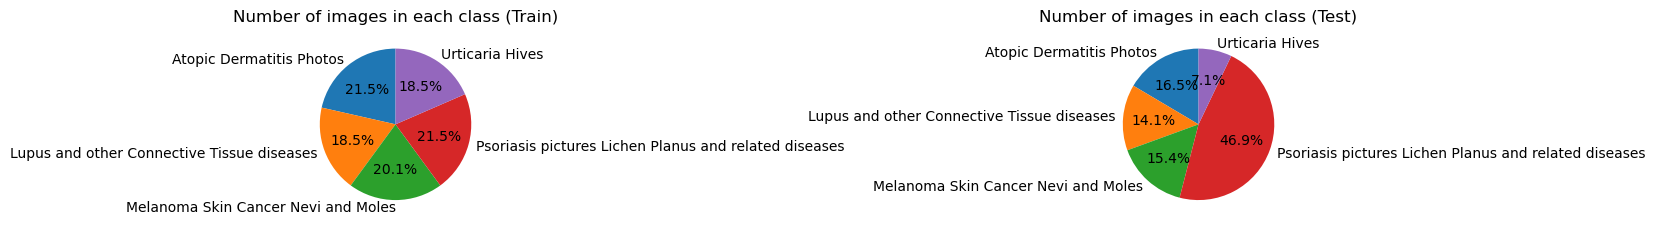

In [2]:
# Função para contar o número de arquivos 
def count_files(directory):
    return len([item for item in os.listdir(directory) if os.path.isfile(os.path.join(directory, item))])

# Caminhos dos diretórios de treino e teste
#train_folder = '/Users/hugopereira/Github/Left4Health_3rdProject/ClassificationOfSkinDiseases/DataProcessed/train'
#test_folder = '/Users/hugopereira/Github/Left4Health_3rdProject/ClassificationOfSkinDiseases/DataProcessed/test'

train_folder= 'C:/Dev/DataProcessed/train'
test_folder = 'C:/Dev/DataProcessed/test'


# Dicionários para armazenar o número de imagens em cada classe de doença de pele
train_diseases = {}
test_diseases = {}

# Função para contar o número de imagens em cada classe de doença de pele 
def count_images_in_folders(folder, diseases_dict):
    for label_folder in os.listdir(folder):
        label_path = os.path.join(folder, label_folder)
        if os.path.isdir(label_path):
            diseases_dict[label_folder] = count_files(label_path)

# Contagem do número de imagens em cada classe de doença de pele 
count_images_in_folders(train_folder, train_diseases)
count_images_in_folders(test_folder, test_diseases)

# Print do número de imagens em cada classe de doença de pele nos conjuntos de treino e teste
for label_folder, num_images in train_diseases.items():
    print(f'Total number of images in [{label_folder.upper()}] in train set: {num_images}')

for label_folder, num_images in test_diseases.items():
    print(f'Total number of images in [{label_folder.upper()}] in test set: {num_images}')

y=list(train_diseases.keys())
print("Labels: ",y)

# Plot do número de imagens em cada classe de doença de pele nos conjuntos de treino e teste 
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.pie(train_diseases.values(), labels=train_diseases.keys(), autopct='%1.1f%%', startangle=90)
plt.title('Number of images in each class (Train)')

plt.subplot(1, 2, 2)
plt.pie(test_diseases.values(), labels=test_diseases.keys(), autopct='%1.1f%%', startangle=90)
plt.title('Number of images in each class (Test)')

plt.tight_layout()
plt.show()

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def get_data(train_folder, test_folder, image_size=(250, 250), batch_size=64):
    # Data augmentation para o conjunto de treinamento
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2,  # Fixando a divisão em 80% treino e 20% validação
        horizontal_flip=True,
        vertical_flip=True,
        rotation_range=20,
        shear_range= 0.4,
        zoom_range=0.2,
        fill_mode='reflect'
    )

    # Carregar dados de treinamento e validação
    train_generator = train_datagen.flow_from_directory(
        train_folder,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training',  # Define o subset como treinamento
        seed=10
    )

    validation_generator = train_datagen.flow_from_directory(
        train_folder,   
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation',  # Define o subset como validação
        seed=10
    )

    # Obtendo o mapeamento de classes para índices
    class_indices = train_generator.class_indices

    # Invertendo o mapeamento para obter índices para classes
    indices_class = {v: k for k, v in class_indices.items()}

    # Inicializando um contador para cada classe
    class_counts_train = {class_name: 0 for class_name in indices_class.values()}

    # Iterando sobre o diretório de treinamento e contando o número de imagens em cada classe
    for class_name in class_counts_train.keys():
        class_folder = os.path.join(train_folder, class_name)
        num_images = len(os.listdir(class_folder))
        class_counts_train[class_name] = num_images

    # Data augmentation para o conjunto de teste
    test_datagen = ImageDataGenerator(rescale=1./255)

    # Carregar dados de teste
    test_generator = test_datagen.flow_from_directory(
        test_folder,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    # Obtendo o número de imagens por classe no conjunto de teste
    class_counts_test = {class_name: len(os.listdir(os.path.join(test_folder, class_name))) for class_name in class_counts_train.keys()}

    # Obtendo o número de imagens por classe no conjunto de validação
    class_counts_validation = {class_name: len(os.listdir(os.path.join(train_folder, class_name))) for class_name in class_counts_train.keys()}

    # Imprimindo o número de imagens para cada classe no conjunto de validação
    print("\nNúmero de imagens por classe no conjunto de validação:")
    for class_name, count in class_counts_validation.items():
        print(f"Classe: {class_name}, Número de Imagens: {count}")
    
    return train_generator, validation_generator, test_generator, class_counts_train, class_counts_test,class_counts_validation

train_generator, validation_generator, test_generator, class_counts_train, class_counts_test,class_counts_validation = get_data(train_folder, test_folder)

# Imprimindo o número de imagens para cada classe no conjunto de treinamento
print("Número de imagens por classe no conjunto de treinamento:")
for class_name, count in class_counts_train.items():
    print(f"Classe: {class_name}, Número de Imagens: {count}")

# Imprimindo o número de imagens para cada classe no conjunto de validação
print("\nNúmero de imagens por classe no conjunto de validação:")
for class_name, count in class_counts_validation.items():
    print(f"Classe: {class_name}, Número de Imagens: {count}")

# Imprimindo o número de imagens para cada classe no conjunto de teste
print("\nNúmero de imagens por classe no conjunto de teste:")
for class_name, count in class_counts_test.items():
    print(f"Classe: {class_name}, Número de Imagens: {count}")


Found 1803 images belonging to 5 classes.
Found 448 images belonging to 5 classes.
Found 746 images belonging to 5 classes.

Número de imagens por classe no conjunto de validação:
Classe: Atopic Dermatitis Photos, Número de Imagens: 483
Classe: Lupus and other Connective Tissue diseases, Número de Imagens: 416
Classe: Melanoma Skin Cancer Nevi and Moles, Número de Imagens: 453
Classe: Psoriasis pictures Lichen Planus and related diseases, Número de Imagens: 483
Classe: Urticaria Hives, Número de Imagens: 416
Número de imagens por classe no conjunto de treinamento:
Classe: Atopic Dermatitis Photos, Número de Imagens: 483
Classe: Lupus and other Connective Tissue diseases, Número de Imagens: 416
Classe: Melanoma Skin Cancer Nevi and Moles, Número de Imagens: 453
Classe: Psoriasis pictures Lichen Planus and related diseases, Número de Imagens: 483
Classe: Urticaria Hives, Número de Imagens: 416

Número de imagens por classe no conjunto de validação:
Classe: Atopic Dermatitis Photos, Númer

In [4]:
def confussion_matrix(y_true_labels,y_pred_labels,test_generator):
    # Calcular a matriz de confusão
    cm = confusion_matrix(y_true_labels, y_pred_labels)

    # Exibir a matriz de confusão
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Calcular os verdadeiros positivos (TP), verdadeiros negativos (TN),
    # falsos positivos (FP) e falsos negativos (FN)
    TP = cm[1, 1]
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]

    # Exibir o relatório de classificação
    print("\nRelatório de Classificação:")
    print(classification_report(y_true_labels, y_pred_labels, target_names=test_generator.class_indices.keys()))

    # Exibir a tabela com os valores de TP, TN, FP, FN
    print("\nValores de TP, TN, FP, FN:")
    print("Verdadeiros Positivos:", TP)
    print("Verdadeiros Negativos:", TN)
    print("Falsos Positivos:", FP)
    print("Falsos Negativos:", FN)

## Carregar os modelos

Carrega os modelos de um tipo específico presentes na pasta indicada.
    
Parâmetros:
    caminho_pasta (str): Caminho da pasta onde os modelos estão salvos.
    tipo_modelo (str): Tipo de modelo desejado.
Retorna:
    list: Lista contendo os modelos do tipo especificado.


In [5]:
import os
from tensorflow.keras.models import load_model

def carregar_modelos_por_tipo(tipo_modelo, caminho_pasta="Models_Saved"):
    modelos_do_tipo = []

    # Percorre os diretórios dentro da pasta
    for dirpath, dirnames, filenames in os.walk(caminho_pasta):
        # Para cada subpasta
        for dirname in dirnames:
            # Verifica se o nome da subpasta contém o tipo de modelo desejado
            if tipo_modelo.lower() in dirname.lower():
                # Caminho da subpasta do tipo de modelo
                caminho_tipo_modelo = os.path.join(dirpath, dirname)
                # Percorre os arquivos nessa subpasta
                for filename in os.listdir(caminho_tipo_modelo):
                    # Verifica se é um arquivo de modelo (por exemplo, com extensão .h5 para Keras)
                    if filename.endswith(".h5"):
                        # Carrega o modelo
                        modelo_path = os.path.join(caminho_tipo_modelo, filename)
                        modelo = load_model(modelo_path)
                        # Adiciona o modelo à lista de modelos do tipo especificado
                        modelos_do_tipo.append(modelo)
    print(f"Importei {len(modelos_do_tipo)} modelos do tipo {tipo_modelo}")
    return modelos_do_tipo


print("Função para carregar os modelos carregada com sucesso")


Função para carregar os modelos carregada com sucesso


In [6]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

def analisar_modelos(lista_modelos, test_generator):
    for modelo_idx, modelo in enumerate(lista_modelos, start=1):
        # Criar uma nova figura para cada modelo
        plt.figure(figsize=(10, 6))
        
        # Resumo do modelo
        summary = modelo.summary()
        print(f"Modelo {modelo_idx}:")
        #print(summary)
        
        # Avaliação do modelo
        score = modelo.evaluate(test_generator)
        print(f"Acurácia do modelo {modelo_idx}: {score[1]}")
        
        # Obtendo as previsões do modelo para os dados de teste
        y_pred = modelo.predict(test_generator)
        # Convertendo as previsões para as classes correspondentes
        y_pred_classes = np.argmax(y_pred, axis=1)
        # Obtendo as verdadeiras classes dos dados de teste
        y_true = test_generator.classes
        # Calculando a matriz de confusão
        matriz_confusao = confusion_matrix(y_true, y_pred_classes)
        
        # Plot da matriz de confusão
        plt.imshow(matriz_confusao, interpolation='nearest', cmap=plt.cm.Blues)
        plt.xticks(np.arange(len(test_generator.class_indices)), test_generator.class_indices.keys(), rotation=45)
        plt.yticks(np.arange(len(test_generator.class_indices)), test_generator.class_indices.keys())
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.title(f"Matriz de Confusão - Modelo {modelo_idx}")
        plt.colorbar()
        plt.show()


print("Função para analisar os modelos carregada com sucesso")

Função para analisar os modelos carregada com sucesso


In [11]:
def encontrar_melhor_modelo_com_generator(modelos, generator):
    # Obtendo o número de amostras no conjunto de teste
    total_samples = len(generator.filenames)

    # Calculando o número de passos necessário para percorrer todo o conjunto de teste
    test_steps = total_samples // generator.batch_size

    melhor_modelo = None
    melhor_precisao = 0.0

    for i, modelo in enumerate(modelos):
        print(f"Avaliando modelo {i+1} de {len(modelos)}...")
        precisao = avaliar_modelo_com_generator(modelo, generator, test_steps)
        print(f"   Precisão do modelo {i+1}: {precisao*100:.2f}%")
        if precisao > melhor_precisao:
            melhor_modelo = modelo
            melhor_precisao = precisao

    return melhor_modelo, melhor_precisao

def avaliar_modelo_com_generator(modelo, generator, steps):
    # Avaliar o modelo usando o gerador de dados
    metrics = modelo.evaluate(generator, steps=steps, verbose=0)
    accuracy = metrics[1]  # Supondo que a precisão seja a segunda métrica
    return accuracy

### CNN

In [8]:
tipo_modelo = "cnn"
modelos_cnn = carregar_modelos_por_tipo(tipo_modelo)

#analisar_modelos(modelos_cnn, test_generator)


Importei 8 modelos do tipo cnn


In [12]:

melhor_modelo_cnn, melhor_precisao_cnn = encontrar_melhor_modelo_com_generator(modelos_cnn, test_generator)
print(f"Melhor modelo CNN tem precisão de {melhor_precisao_cnn*100:.2f}%")

Avaliando modelo 1 de 8...
   Precisão do modelo 1: 45.31%
Avaliando modelo 2 de 8...
   Precisão do modelo 2: 49.72%
Avaliando modelo 3 de 8...
   Precisão do modelo 3: 49.72%
Avaliando modelo 4 de 8...
   Precisão do modelo 4: 21.31%
Avaliando modelo 5 de 8...
   Precisão do modelo 5: 44.60%
Avaliando modelo 6 de 8...
   Precisão do modelo 6: 17.47%
Avaliando modelo 7 de 8...
   Precisão do modelo 7: 17.47%
Avaliando modelo 8 de 8...
   Precisão do modelo 8: 17.47%
Melhor modelo CNN tem precisão de 49.72%


### ResNet

In [13]:
tipo_modelo="resnet"
modelos_resnet = carregar_modelos_por_tipo(tipo_modelo)

#analisar_modelos(modelos_resnet, test_generator)

Importei 4 modelos do tipo resnet


In [14]:
melhor_modelo_resnet, melhor_precisao_resnet = encontrar_melhor_modelo_com_generator(modelos_resnet, test_generator)
print(f"Melhor modelo Resnet tem precisão de {melhor_precisao_resnet*100:.2f}%")

Avaliando modelo 1 de 4...
   Precisão do modelo 1: 21.31%
Avaliando modelo 2 de 4...
   Precisão do modelo 2: 21.73%
Avaliando modelo 3 de 4...
   Precisão do modelo 3: 21.73%
Avaliando modelo 4 de 4...
   Precisão do modelo 4: 21.73%
Melhor modelo Resnet tem precisão de 21.73%


### VGG16

In [15]:
tipo_modelo = "vgg16"
modelos_vgg = carregar_modelos_por_tipo( tipo_modelo)

#analisar_modelos(modelos_resnet, test_generator)

Importei 3 modelos do tipo vgg16


In [16]:
melhor_modelo_vgg, melhor_precisao_vgg = encontrar_melhor_modelo_com_generator(modelos_vgg, test_generator)
print(f"Melhor modelo VGG tem precisão de {melhor_precisao_vgg*100:.2f}%")

Avaliando modelo 1 de 3...
   Precisão do modelo 1: 49.72%
Avaliando modelo 2 de 3...
   Precisão do modelo 2: 49.72%
Avaliando modelo 3 de 3...
   Precisão do modelo 3: 49.72%
Melhor modelo VGG tem precisão de 49.72%


### Densenet

In [18]:
tipo_modelo = "densenet"
modelos_densenet = carregar_modelos_por_tipo(tipo_modelo)

#analisar_modelos(modelos_resnet, test_generator)

Importei 1 modelos do tipo densenet


In [19]:
melhor_modelo_densenet, melhor_precisao_densenet = encontrar_melhor_modelo_com_generator(modelos_densenet, test_generator)
print(f"Melhor modelo Densenet tem precisão de {melhor_precisao_densenet*100:.2f}%")

Avaliando modelo 1 de 1...
   Precisão do modelo 1: 21.31%
Melhor modelo Densenet tem precisão de 21.31%


## Best Model

In [25]:
def salvar_melhor_modelo_global(melhor_modelo_global, tipo_modelo, pasta_destino="melhores_modelos"):
    # Criar o nome da pasta de destino se ela não existir
    if not os.path.exists(pasta_destino):
        os.makedirs(pasta_destino)

    # Salvar o modelo no diretório de destino
    destino_modelo = os.path.join(pasta_destino, f"melhor_modelo_{tipo_modelo}.h5")
    melhor_modelo_global.save(destino_modelo)
    print(f"Melhor modelo do tipo {tipo_modelo} salvo em {destino_modelo}")


In [21]:
def encontrar_melhor_modelo_global(melhores_modelos, melhores_precisoes):
    melhor_modelo_global = None
    melhor_precisao_global = 0.0

    for modelo, precisao in zip(melhores_modelos, melhores_precisoes):
        if precisao > melhor_precisao_global:
            melhor_modelo_global = modelo
            melhor_precisao_global = precisao

    return melhor_modelo_global, melhor_precisao_global

In [23]:
# Supondo que você tenha os melhores modelos e as melhores precisões de cada tipo de modelo
melhores_modelos = [melhor_modelo_cnn, melhor_modelo_vgg, melhor_modelo_resnet, melhor_modelo_densenet]
melhores_precisoes = [melhor_precisao_cnn, melhor_precisao_vgg, melhor_precisao_resnet, melhor_precisao_densenet]

melhor_modelo_global, melhor_precisao_global = encontrar_melhor_modelo_global(melhores_modelos, melhores_precisoes)
print(f"Melhor modelo global tem precisão de {melhor_precisao_global*100:.2f}%")

Melhor modelo global tem precisão de 49.72%


In [27]:
# Definir o tipo do modelo
tipos_modelo = ['cnn', 'vgg', 'resnet', 'densenet']

# Encontrar o índice do melhor modelo na lista de modelos
indice_melhor_modelo = melhores_modelos.index(melhor_modelo_global)

# Salvar o melhor modelo global com o tipo de modelo correspondente
tipo_modelo = tipos_modelo[indice_melhor_modelo]
pasta_destino = f"melhor_modelo_{tipo_modelo}"

salvar_melhor_modelo_global(melhor_modelo_global, tipo_modelo, pasta_destino)


Melhor modelo do tipo cnn salvo em melhor_modelo_cnn\melhor_modelo_cnn.h5
